In [640]:
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

from scipy import stats
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
import statsmodels
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import Timestamp

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor

# import warnings
# warnings.filterwarnings('ignore')

In [473]:
data = pd.read_csv('DF_File_sample.csv')
data['SKU_Customer'] = data['DemandCustomer'] + '_' + data['SKU10']
data_labels = data['SKU_Customer'] 
data.drop(['DemandCustomer', 'SKU10'], axis =1, inplace = True)

### Label Encoding:

In [313]:
cat_var = [data.columns.get_loc(c) for c in data.columns if data.loc[:, c].dtypes=='object']

In [314]:
le = preprocessing.LabelEncoder()

for i in cat_var:
    data.iloc[:, i] = le.fit_transform(data.iloc[:, i])

### Categorical:

In [7]:
for c in cat_var:
    data.iloc[:, c] = pd.Categorical(data.iloc[:,c])

### One Hot Encoder:

In [474]:
data_OH = pd.get_dummies(data)

In [475]:
data = data_OH.copy()

## Data cleaning:

#### agg sales by month

In [476]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['pre_date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))

In [477]:
first_null = data.groupby('pre_date').Sales.sum().loc[lambda x: x == 0].sort_values().index[0]
data = data[data.pre_date < first_null]

In [478]:
first_null

Timestamp('2019-04-18 00:00:00')

In [479]:
first_26_week = pd.Series(sorted(data['pre_date'].unique())).iloc[-26]

In [480]:
first_34_week = pd.Series(sorted(data['pre_date'].unique())).iloc[-34]

In [481]:
train = data[data['pre_date'] < first_34_week]
test = data[data['pre_date'] >= first_26_week]
data.drop(['pre_date', 'year_week'], axis =1, inplace = True)
train.drop(['pre_date', 'year_week'], axis =1, inplace = True)
test.drop(['pre_date', 'year_week'], axis =1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [482]:
test0 = test.copy()
test0['SKU_Customer'] = test0.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
test['Sales'] = test0.groupby(['SKU_Customer', 'Year', 'Month_No']).Sales.transform('sum')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [483]:
X_train = train.loc[:, train.columns!='Sales']
X_test = test.loc[:, test.columns!='Sales']
y_train = train['Sales']
y_test = test['Sales']

In [484]:
def diff_scale(scaling_type = 'norm', X_train = X_train, X_test = X_test):
    norm_scaler = preprocessing.StandardScaler()
    min_max_scaler = preprocessing.MinMaxScaler() # [0, 1]
    max_abs_scaler = preprocessing.MaxAbsScaler() # [-1, 1]
    if scaling_type == 'norm':
        X_train_scaled = norm_scaler.fit_transform(X_train)
        X_test_scaled = norm_scaler.transform(X_test)
    elif scaling_type == 'min_max':
        X_train_scaled = min_max_scaler.fit_transform(X_train)
        X_test_scaled = min_max_scaler.transform(X_test)
    else: 
        X_train_scaled = max_abs_scaler.fit_transform(X_train)
        X_test_scaled = max_abs_scaler.transform(X_test) 
    return X_train_scaled, X_test_scaled

In [650]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)

### scale by column(for categorical variables):

In [485]:
def scale_by_col(df, scaler):
    for var in df.select_dtypes(['number']).columns:
        df[var] = scaler.fit_transform(df[var].values.reshape(-1,1))
    return df

In [294]:
X_train_с_scaled = scale_by_col(X_train_c, norm_scaler)
X_test_c_scaled = scale_by_col(X_test_c, norm_scaler)

### Eval func:

In [ ]:
# Mape by every row
def mape(y, y_pred): 
    Data = {'y': np.array(y),
            'y_pred': np.array(y_pred)}
    Data['MAPE'] = np.where((Data['y_pred'] == 0)&(Data['y'] == 0), 0, \
                           np.where((Data['y_pred'] != 0)&(Data['y']==0),1, np.abs(Data['y_pred']-Data['y'])*100/Data['y']))
    
    return Data['MAPE'].mean()

In [486]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) * 100 / np.mean(np.abs(y_true))

In [487]:
def mape_by_month(y_true, y_pred): 
    test2 = test.copy()
    test2['Sales_pred'] = y_pred
    test2['SKU_Customer'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
    test2['Sales_pred'] = test2.groupby(['Year', 'Month_No', 'SKU_Customer']).Sales_pred.transform('mean')
    return mape(test['Sales'], test2['Sales_pred'])

In [488]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [489]:
def rmse_by_month(y_true, y_pred): 
    test2 = test.copy()
    test2['Sales_pred'] = y_pred
    test2['SKU_Customer'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
    test2['Sales_pred'] = test2.groupby(['SKU_Customer', 'Year', 'Month_No']).Sales_pred.transform('mean')
    return rmse(test['Sales'], test2['Sales_pred'])

In [490]:
def MAD_by_month(y, y_pred):
    Data = {'y': np.array(y),
            'y_pred': np.array(y_pred)}
    
    test2 = test.copy()
    test2['y_pred'] = Data['y_pred']
    test2['SKU_Customer'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
    test2['y_pred'] = test2.groupby(['Year', 'Month_No', 'SKU_Customer']).y_pred.transform('mean')
    Data['y_pred'] = test2['y_pred']
    
    Data['MAD'] = np.where((Data['y_pred'] == 0)&(Data['y'] == 0), 0, \
                           np.where((Data['y_pred'] == 0)&(Data['y']!=0),1, np.abs(Data['y_pred']-Data['y'])/Data['y_pred']))
    return Data['MAD'].mean()

# Modeling:

## Ridge: 

In [651]:
alphas = np.arange(0, 1, 0.01)
fit_interceptOptions = ([True, False])

model = Ridge() 
scorer = make_scorer(mape, greater_is_better=False)

ridge_cv = GridSearchCV(model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
ridge_cv.fit(X_train_scaled, y_train)

print("ridge mape:", mape_by_month(y_test, ridge_cv.predict(X_test_scaled)), ridge_cv.best_params_)
print("ridge rmse:", rmse_by_month(y_test, ridge_cv.predict(X_test_scaled)))
print("ridge MAD:", MAD_by_month(y_test, ridge_cv.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ridge mape: 78.26210458316488 {'alpha': 0.99, 'fit_intercept': True}
ridge rmse: 4449.260697701879
ridge MAD: 2.779961216820889


## Lasso:

In [204]:
alphas = np.arange(0, 1, 0.01)
fit_interceptOptions = ([True, False])

model = Lasso() 
scorer = make_scorer(mape, greater_is_better=False)

lasso_cv = GridSearchCV(model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
lasso_cv.fit(X_train_scaled, y_train)

print("lasso mape:", mape_by_month(y_test, lasso_cv.predict(X_test_scaled)), lasso_cv.best_params_)
print("lasso rmse:", rmse_by_month(y_test, lasso_cv.predict(X_test_scaled)))
print("lasso MAD:", MAD_by_month(y_test, lasso_cv.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


lasso mape: 43.844628487904465 {'alpha': 0.29, 'fit_intercept': True}
lasso rmse: 582.8834310653247
ridge rmse: 0.6283063149358187


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19725414.66720009, tolerance: 1416151.2387218715
  positive)


## ElasticNet:

In [205]:
alphas = np.logspace(-5,2,8)
l1_ratio = [.1, .15, .2, .25, .3,.4,.5,.6,.8]
fit_interceptOptions = ([True, False])

model = ElasticNet() 
scorer = make_scorer(mape, greater_is_better=False)

ElasticNet_cv = GridSearchCV(model, param_grid=dict(alpha=alphas, l1_ratio = l1_ratio, fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
ElasticNet_cv.fit(X_train_scaled, y_train)

print("ElasticNet mape:", mape_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)), ElasticNet_cv.best_params_)
print("ElasticNet rmse:", rmse_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)))
print("ElasticNet MAD:", MAD_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNet mape: 43.89520986906346 {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.8}
ElasticNet rmse: 583.4014421480716
ElasticNet MAD: 0.6331462398547043


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14776034.158023834, tolerance: 1416151.2387218715
  positive)


In [187]:
alphas = [.009, .01, .015, .02,.05,.1]
l1_ratio = [.1,.2,.3,.4,.5,.55, .6, .65,.7,.8]
fit_interceptOptions = ([True, False])

model = ElasticNet() 
scorer = make_scorer(mape, greater_is_better=False)

ElasticNet_cv = GridSearchCV(model, param_grid=dict(alpha=alphas, l1_ratio = l1_ratio, fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
ElasticNet_cv.fit(X_train_scaled, y_train)

print("ElasticNet mape:", mape_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)), ElasticNet_cv.best_params_)
print("ElasticNet rmse:", rmse_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)))
print("ElasticNet MAD:", MAD_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNet mape: 43.88760884080415 {'alpha': 0.009, 'fit_intercept': True, 'l1_ratio': 0.8}
ElasticNet rmse: 583.3577674291163


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596096359.1907067, tolerance: 1416151.2387218715
  positive)


#### Lasso takes the best result => tune diff scaling

### tune diff scaling:

##### min_max

In [260]:
X_train_scaled, X_test_scaled = diff_scale('min_max', X_train, X_test)
alphas = np.logspace(-5,2,8)
l1_ratio = [.1, .15, .2, .25, .3,.4,.5,.6,.8]

model = ElasticNet()  
scorer = make_scorer(mape, greater_is_better=False)

ElasticNet_cv_mm = GridSearchCV(model, param_grid=dict(alpha=alphas, l1_ratio=l1_ratio,fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
ElasticNet_cv_mm.fit(X_train_scaled, y_train)

print("Lasso mape:", mape_by_month(y_test, ElasticNet_cv_mm.predict(X_test_scaled)), ElasticNet_cv_mm.best_params_)
print("ElasticNet rmse:", rmse_by_month(y_test, ElasticNet_cv_mm.predict(X_test_scaled)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Lasso mape: 50.17694271242768 {'alpha': 10.0, 'fit_intercept': False, 'l1_ratio': 0.8}
ElasticNet rmse: 351.0281888887466


##### max_abs

In [261]:
X_train_scaled, X_test_scaled = diff_scale('max_abs', X_train, X_test)
alphas = np.logspace(-5,2,8)
l1_ratio = [.1, .15, .2, .25, .3,.4,.5,.6,.8]

model = ElasticNet()  
scorer = make_scorer(mape, greater_is_better=False)

ElasticNet_cv_ma = GridSearchCV(model, param_grid=dict(alpha=alphas, l1_ratio=l1_ratio,fit_intercept=fit_interceptOptions), scoring = scorer, n_jobs=-2)
ElasticNet_cv_ma.fit(X_train_scaled, y_train)

print("Lasso mape:", mape_by_month(y_test, ElasticNet_cv_ma.predict(X_test_scaled)), ElasticNet_cv_mm.best_params_)
print("ElasticNet rmse:", rmse_by_month(y_test, ElasticNet_cv_ma.predict(X_test_scaled)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Lasso mape: 62.50765658487119 {'alpha': 10.0, 'fit_intercept': False, 'l1_ratio': 0.8}
ElasticNet rmse: 426.73585900075085


# SVR:

In [562]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
parameters = {'kernel': ('linear', 'rbf','poly'),
              'C':[1.5, 10],
              'gamma': [1e-7, 1e-4],
              'epsilon':[0.1,0.2,0.5,0.3]}

model = SVR()
scorer = make_scorer(mape, greater_is_better=False)
svr = GridSearchCV(model, parameters, scoring = scorer, n_jobs=-2)
svr.fit(X_train_scaled, y_train)

print("SVR mape:", mape_by_month(y_test, svr.predict(X_test_scaled)), svr.best_params_)
print("SVR rmse:", rmse_by_month(y_test, svr.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVR mape: 82.48684969248089 {'C': 1.5, 'epsilon': 0.3, 'gamma': 1e-07, 'kernel': 'linear'}
SVR rmse: 4638.55357824556


In [563]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
parameters = {'kernel': ['linear'],
              'C':[1, 2, 4, 5],
              'gamma': [1e-10, 1e-9, 1e-8, 1e-7],
              'epsilon':[.3, .35, .45, .5]}
 
model = SVR()
scorer = make_scorer(mape, greater_is_better=False)
svr = GridSearchCV(model, parameters, scoring = scorer, n_jobs=-2)
svr.fit(X_train_scaled, y_train)

print("SVR mape:", mape_by_month(y_test, svr.predict(X_test_scaled)), svr.best_params_)
print("SVR rmse:", rmse_by_month(y_test, svr.predict(X_test_scaled)))
print("SVR MAD:", MAD_by_month(y_test, ElasticNet_cv.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVR mape: 82.32578475959185 {'C': 2, 'epsilon': 0.45, 'gamma': 1e-10, 'kernel': 'linear'}
SVR rmse: 4630.3285453342405
SVR MAD: 2.81015437625592


## Lightgbm with k-Fold:

## 5

In [492]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)
                                                  
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, n_jobs = -2)


gbm.fit(X_train_scaled, y_train)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


lightgbm mape: 82.13935749134242 {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 160, 'num_leaves': 9}
lightgbm rmse: 4510.713280213905


## 7

In [518]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)
                                                  
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   cv = 7,
                   n_jobs = -2)


gbm.fit(X_train_scaled, y_train)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 78.86952945136558 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 170, 'num_leaves': 8}
lightgbm rmse: 4422.83835990909


## 10

In [519]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)
                                                  
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   cv = 10,
                   n_jobs = -2)


gbm.fit(X_train_scaled, y_train)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 78.81297203627314 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 170, 'num_leaves': 8}
lightgbm rmse: 4422.940683731223


# Lightgbm with Group k-Fold:

In [566]:
groups = X_train['Year'].astype(str) + '_' + X_train['Week_No'].astype(str) 

In [505]:
groups = X_train[['Year', 'Week_No']].values

###  5

In [653]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1, .2, .3]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm_g1 = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=5))


gbm_g1.fit(X_train_scaled, y_train, groups=groups)

print("lightgbm mape:", mape_by_month(y_test, gbm_1.predict(X_test_scaled)), gbm_g1.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm_g1.predict(X_test_scaled)))

lightgbm mape: 77.56147635770547 {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 170, 'num_leaves': 9}
lightgbm rmse: 4368.990213180459


In [652]:
# use parametesr into models:
gbm_g1_result = lgb.LGBMRegressor(cat_features= cat_var, max_depth=7, n_estimators=170, learning_rate=0.2, num_leaves=9).fit(X_train_scaled, y_train)
print("XGB mape:", mape_by_month(y_test, gbm_g1_result.predict(X_test_scaled)))
print("XGB rmse:", rmse(y_test, gbm_g1_result.predict(X_test_scaled)))

XGB mape: 77.56147635770547
XGB rmse: 4368.990213180459


### 6

In [517]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1, .2, .3]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=6))


gbm.fit(X_train_scaled, y_train, groups=groups)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 78.59512841291054 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 170, 'num_leaves': 9}
lightgbm rmse: 4413.7326235717


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 8

In [534]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1, .2, .3]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=8))


gbm.fit(X_train_scaled, y_train, groups=groups)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 77.96815178417387 {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 170, 'num_leaves': 8}
lightgbm rmse: 4386.864356700242


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 12

In [535]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1, .2, .3]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=12))


gbm.fit(X_train_scaled, y_train, groups=groups)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 77.81430366609294 {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 170, 'num_leaves': 9}
lightgbm rmse: 4363.915162900023


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 10

In [536]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : list(range(100, 180,10)),
    'num_leaves': list(range(7,10, 1)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [2, 4, 6, 7, 8],
    'learning_rate': [0.01, .016, .02, .1, .2, .3]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=10))


gbm.fit(X_train_scaled, y_train, groups=groups)

print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 78.07847265417618 {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 170, 'num_leaves': 8}
lightgbm rmse: 4406.06631028755


#### tuning another parameters:

In [539]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : [170],
    'num_leaves': [9],
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [7],
    'learning_rate': [.2],
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)}

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=5))


gbm.fit(X_train_scaled, y_train, groups=groups)
print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 77.65397911725476 {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 170, 'num_leaves': 9, 'reg_alpha': 0.1, 'reg_lambda': 0.3833333333333333}
lightgbm rmse: 4364.7998910684055


In [554]:
X_train_scaled, X_test_scaled = diff_scale('norm', X_train, X_test)
param_grid = {
    'n_estimators' : [170],
    'num_leaves': [9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [7],
    'learning_rate': [.2],
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, .9, 10),
    'reg_lambda': np.linspace(0.1, 0.9, 10)}

    
scorer = make_scorer(mape, greater_is_better = False)   
gbm = GridSearchCV(lgb.LGBMRegressor(cat_features= cat_var), 
                   param_grid, 
                   scoring = scorer, 
                   n_jobs = -2,
                   cv = GroupKFold(n_splits=5))


gbm.fit(X_train_scaled, y_train, groups=groups)
print("lightgbm mape:", mape_by_month(y_test, gbm.predict(X_test_scaled)), gbm.best_params_)
print("lightgbm rmse:", rmse(y_test, gbm.predict(X_test_scaled)))

lightgbm mape: 77.83103272916486 {'learning_rate': 0.2, 'max_depth': 7, 'min_data_in_leaf': 10, 'n_estimators': 170, 'num_leaves': 9, 'reg_alpha': 0.7222222222222222, 'reg_lambda': 0.2777777777777778}
lightgbm rmse: 4349.254952177309


# XGB

In [523]:
param_grid = {
    'n_estimators' : list(range(150, 400, 50)),
    # 'num_leaves': list(range(8, 16, 4)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [8, 12, 15],
    'learning_rate': [.3, 0.1, 0.01]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)
                          
scorer = make_scorer(mape, greater_is_better = False) 
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror')                        

    
grid_xgb = GridSearchCV(model_xgb, 
                        param_grid, 
                        scoring = scorer,
                        n_jobs=-2,
                        verbose=2,
                        cv = GroupKFold(n_splits=10))

grid_xgb.fit(X_train_scaled, y_train, groups = groups)

print("XGB mape:", mape_by_month(y_test, grid_xgb.predict(X_test_scaled)), grid_xgb.best_params_)
print("XGB rmse:", rmse(y_test, grid_xgb.predict(X_test_scaled)))

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 343 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-2)]: Done 450 out of 450 | elapsed:  8.0min finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB mape: 77.30885861479051 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
XGB rmse: 4324.4381240720095


In [549]:
param_grid = {
    'n_estimators' : [200],
    'num_leaves': list(range(8, 17, 3)),
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [8, 9],
    'learning_rate': [.09, .1, 0.15]}
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    # 'reg_alpha': np.linspace(0.1, 0.95, 10),
    # 'reg_lambda': np.linspace(0.1, 0.95, 10)
                          
scorer = make_scorer(mape, greater_is_better = False) 
model_xgb_1 = xgb.XGBRegressor(objective = 'reg:squarederror')                        

    
model_xgb_1 = GridSearchCV(model_xgb, 
                        param_grid, 
                        scoring = scorer,
                        n_jobs=-2,
                        verbose=2,
                        cv = GroupKFold(n_splits=5))

grid_xgb_1.fit(X_train_scaled, y_train, groups = groups)

print("XGB mape:", mape_by_month(y_test, model_xgb_1.predict(X_test_scaled)), model_xgb_1.best_params_)
print("XGB rmse:", rmse(y_test, model_xgb_1.predict(X_test_scaled)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:   47.7s finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB mape: 77.30885861479051 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'num_leaves': 8}
XGB rmse: 4324.4381240720095


In [551]:
param_grid = {
    'n_estimators' : [200],
    'num_leaves': [8],
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [8, 9],
    'learning_rate': [.1],
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)}
                          
scorer = make_scorer(mape, greater_is_better = False) 
model_xgb_2 = xgb.XGBRegressor(objective = 'reg:squarederror')                        

    
model_xgb_2 = GridSearchCV(model_xgb, 
                        param_grid, 
                        scoring = scorer,
                        n_jobs=-2,
                        verbose=2,
                        cv = GroupKFold(n_splits=5))

model_xgb_2.fit(X_train_scaled, y_train, groups = groups)

print("XGB mape:", mape_by_month(y_test, model_xgb_2.predict(X_test_scaled)), model_xgb_2.best_params_)
print("XGB rmse:", rmse(y_test, model_xgb_2.predict(X_test_scaled)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 343 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 626 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:  9.6min finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB mape: 77.30885861479051 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'num_leaves': 8, 'reg_alpha': 0.28888888888888886, 'reg_lambda': 0.5722222222222222}
XGB rmse: 4324.4381240720095


#### try to use simple CV:

In [659]:
param_grid = {
    'n_estimators' : [200],
    'num_leaves': [8],
    # 'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [8, 9],
    'learning_rate': [.1],
    # 'bagging_freq': [3, 4, 5, 6, 7],
    # 'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)}
                          
scorer = make_scorer(mape, greater_is_better = False) 
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror')                        

    
grid_xgb_3 = GridSearchCV(model_xgb, 
                        param_grid, 
                        scoring = scorer,
                        n_jobs=-2,
                        verbose=2,
                        cv = 5)

grid_xgb_3.fit(X_train_scaled, y_train)

print("XGB mape:", mape_by_month(y_test, grid_xgb_3.predict(X_test_scaled)), grid_xgb_3.best_params_)
print("XGB rmse:", rmse(y_test, grid_xgb_3.predict(X_test_scaled)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 343 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 626 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:  9.9min finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB mape: 77.18610178943412 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'num_leaves': 8, 'reg_alpha': 0.8555555555555555, 'reg_lambda': 0.95}
XGB rmse: 4330.045389777716


In [574]:
# use parametesr into models:
grid_xgb_result = xgb.XGBRegressor(objective = 'reg:squarederror', max_depth=9, n_estimators=200, learning_rate=0.1, num_leaves=8, reg_alpha=0.8555555555555555, reg_lambda=0.95).fit(X_train_scaled, y_train)
print("XGB mape:", mape_by_month(y_test, grid_xgb_result.predict(X_test_scaled)))
print("XGB rmse:", rmse(y_test, grid_xgb_result.predict(X_test_scaled)))

XGB mape: 77.18610178943412
XGB rmse: 4330.045389777716


In [649]:
ridge_cv.predict(X_test_scaled)

ValueError: shapes (1248,56) and (58,) not aligned: 56 (dim 1) != 58 (dim 0)

In [654]:
pd.DataFrame(grid_xgb_result.predict(X_test_scaled),
            gbm_1.predict(X_test_scaled),
            ridge_cv.predict(X_test_scaled))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55']
expected f56 in input data

# Ensemble:

In [ ]:
# Simple Linear model

In [642]:
from sklearn linear_model
stacker= linear_model.LinearRegression()
stacker.fit(pd.DataFrame(grid_xgb_result.predict(X_test_scaled),
            gbm_1.predict(X_test_scaled),
            ridge_cv.predict(X_test_scaled)),
            X_test_scaled)

print("stacker mape:", mape_by_month(y_test, stregr.predict(X_test_scaled)))
print("stacker rmse:", rmse(y_test, stregr.predict(X_test_scaled)))

StackingRegressor(meta_regressor=GridSearchCV(cv='warn',
                                              error_score='raise-deprecating',
                                              estimator=Ridge(alpha=1.0,
                                                              copy_X=True,
                                                              fit_intercept=True,
                                                              max_iter=None,
                                                              normalize=False,
                                                              random_state=None,
                                                              solver='auto',
                                                              tol=0.001),
                                              iid='warn', n_jobs=-2,
                                              param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 

## mlxtend:

In [576]:
from mlxtend.regressor import StackingRegressor

stregr_1 = StackingRegressor(regressors=[gbm_g1_result, grid_xgb_result, svr], 
                           meta_regressor=ridge_cv)

stregr_1.fit(X_train_scaled, y_train)

print("stregr_1 mape:", mape_by_month(y_test, stregr.predict(X_test_scaled)))
print("stregr_1 rmse:", rmse(y_test, stregr.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


XGB mape: 77.13224507532261
XGB rmse: 4326.8949875543485


In [637]:
from mlxtend.regressor import StackingRegressor

stregr_1 = StackingRegressor(regressors=[gbm_g1_result, grid_xgb_result, svr], 
                             meta_regressor=ridge_cv,
                             use_features_in_secondary=True)

stregr_1.fit(X_train_scaled, y_train)

print("stregr_1 mape:", mape_by_month(y_test, stregr.predict(X_test_scaled)))
print("stregr_1 rmse:", rmse(y_test, stregr.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


stregr_1 mape: 77.15165151557427
stregr_1 rmse: 4327.477517306288


### w/o SVR:

In [577]:
from mlxtend.regressor import StackingRegressor

stregr_2 = StackingRegressor(regressors=[gbm_g1_result, grid_xgb_result], 
                           meta_regressor=ridge_cv)

stregr_2.fit(X_train_scaled, y_train)

print("stregr_2 mape:", mape_by_month(y_test, stregr_2.predict(X_test_scaled)))
print("stregr_2 rmse:", rmse(y_test, stregr_2.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


XGB mape: 77.15165151557427
XGB rmse: 4327.477517306288


In [638]:
from mlxtend.regressor import StackingRegressor

stregr_2 = StackingRegressor(regressors=[gbm_g1_result, grid_xgb_result], 
                             meta_regressor=ridge_cv,
                             use_features_in_secondary=True)

stregr_2.fit(X_train_scaled, y_train)

print("stregr_2 mape:", mape_by_month(y_test, stregr_2.predict(X_test_scaled)))
print("stregr_2 rmse:", rmse(y_test, stregr_2.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


stregr_2 mape: 77.10670822781684
stregr_2 rmse: 4327.203301896387


### w/o SVR & use_features_in_secondary=True:

In [580]:
from mlxtend.regressor import StackingRegressor

stregr_2 = StackingRegressor(regressors=[gbm_g1_result, grid_xgb_result], 
                            meta_regressor=ridge_cv)

stregr_2.fit(X_train_scaled, y_train)

print("stregr_2 mape:", mape_by_month(y_test, stregr_2.predict(X_test_scaled)))
print("stregr_2 rmse:", rmse(y_test, stregr_2.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


stregr_2 mape: 77.10670822781684
stregr_2 rmse: 4327.203301896387


In [636]:
stregr_3 = StackingRegressor(regressors=[ridge_cv, grid_xgb_result], 
                            meta_regressor=gbm_g1_result,
                            use_features_in_secondary=True)

stregr_3.fit(X_train_scaled, y_train)

print("stregr_3 mape:", mape_by_month(y_test, stregr_3.predict(X_test_scaled)))
print("stregr_3 rmse:", rmse(y_test, stregr_3.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


stregr_3 mape: 76.49314308564793
stregr_3 rmse: 4260.199986596819


### all models, but meta_regressor = lightgbm

In [581]:
from mlxtend.regressor import StackingRegressor

stregr_3 = StackingRegressor(regressors=[ridge_cv, grid_xgb_result, svr], 
                            meta_regressor=gbm_g1_result)

stregr_3.fit(X_train_scaled, y_train)

print("stregr_3 mape:", mape_by_month(y_test, stregr_3.predict(X_test_scaled)))
print("stregr_3 rmse:", rmse(y_test, stregr_3.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


stregr_3 mape: 76.4909991551237
stregr_3 rmse: 4260.9201545274855


### all models, but meta_regressor = lightgbm & use_features_in_secondary=True

In [579]:
from mlxtend.regressor import StackingRegressor

stregr_3 = StackingRegressor(regressors=[ridge_cv, grid_xgb_result, svr], 
                            meta_regressor=gbm_g1_result,
                            use_features_in_secondary=True)

stregr_3.fit(X_train_scaled, y_train)

print("stregr_3 mape:", mape_by_month(y_test, stregr_3.predict(X_test_scaled)))
print("stregr_3 rmse:", rmse(y_test, stregr_3.predict(X_test_scaled)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


XGB mape: 76.42096805754505
XGB rmse: 4258.359350488903


## TPOT:

In [605]:
from tpot import TPOTRegressor
from tpot.builtins import StackingEstimator
from sklearn.pipeline import make_pipeline, make_union

In [598]:
tpot = TPOTRegressor(generations=8, population_size=50, verbosity=2)
tpot.fit(X_train_scaled, y_train)

print("stregr_3 mape:", mape_by_month(y_test, tpot.predict(X_test_scaled)))

Generation 1 - Current best internal CV score: -1250958.359196122
Generation 2 - Current best internal CV score: -1250958.359196122
Generation 3 - Current best internal CV score: -1250958.359196122
Generation 4 - Current best internal CV score: -1250958.359196122
Generation 5 - Current best internal CV score: -1247403.7385499007
Generation 6 - Current best internal CV score: -1246578.0061185411
Generation 7 - Current best internal CV score: -1245702.6176878647
Generation 8 - Current best internal CV score: -1245499.7739479125

Best pipeline: ExtraTreesRegressor(ZeroCount(ElasticNetCV(LassoLarsCV(Normalizer(ElasticNetCV(input_matrix, l1_ratio=0.6000000000000001, tol=0.01), norm=l1), normalize=False), l1_ratio=0.6000000000000001, tol=0.01)), bootstrap=True, max_features=0.2, min_samples_leaf=10, min_samples_split=4, n_estimators=100)
-19456399.769313164


In [601]:
print("tpot mape:", mape_by_month(y_test, tpot.predict(X_test_scaled)))

tpot mape: 78.09983868224177


In [ ]:
tpot

### use only StackingEstimator:

In [619]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ridge_cv),
    gbm_g1_result)

exported_pipeline.fit(X_train_scaled, y_train)
results = exported_pipeline.predict(X_test_scaled)
print("tpot mape:", mape_by_month(y_test, results))

tpot mape: 76.33902460458779


In [623]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=grid_xgb_result),
    gbm_g1_result)

exported_pipeline.fit(X_train_scaled, y_train)
results = exported_pipeline.predict(X_test_scaled)
print("tpot mape:", mape_by_month(y_test, results))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


tpot mape: 76.41617182539356


In [632]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=grid_xgb_result),
    StackingEstimator(estimator=ridge_cv),
    StackingEstimator(estimator=svr),
    gbm_g1_result)

exported_pipeline.fit(X_train_scaled, y_train)
results = exported_pipeline.predict(X_test_scaled)
print("tpot mape:", mape_by_month(y_test, results))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [633]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ridge_cv),
    StackingEstimator(estimator=grid_xgb_result),
    gbm_g1_result)

exported_pipeline.fit(X_train_scaled, y_train)
results = exported_pipeline.predict(X_test_scaled)
print("tpot mape:", mape_by_month(y_test, results))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


tpot mape: 76.1833432870904


In [639]:
# 77.106
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=gbm_g1_result),
    StackingEstimator(estimator=grid_xgb_result),
    ridge_cv)

exported_pipeline.fit(X_train_scaled, y_train)
results = exported_pipeline.predict(X_test_scaled)
print("tpot mape:", mape_by_month(y_test, results))

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tpot mape: 76.53996226486204


# Result:

In [416]:
test2 = test.copy()
test2['y_pred'] = np.array(ridge_cv.predict(X_test_scaled))
test2['Customer_SKU'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
test2['y_pred'] = np.array(test2.groupby(['Customer_SKU', 'Year', 'Month_No', ]).y_pred.transform('sum'))

final_data = test2[['Sales', 'y_pred', 'Customer_SKU', 'Year', 'Month_No']]
final_data = final_data.drop_duplicates()


final_data['MAD'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] == 0)&(final_data['Sales']!=0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['y_pred']))
 
final_data['MAPE'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] != 0)&(final_data['Sales']==0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['Sales']))

    
print(final_data['MAD'].mean())   
print(final_data['MAPE'].mean())     
print(rmse_by_month(final_data['Sales'], final_data['y_pred']))   

0.5992973208205112
2.3539111203391774
2311.4984864314583


In [346]:
final_data

,Sales,y_pred,SKU_Customer,Year,Month_No,MAD,MAPE
198,908.00,1355.940948,ALL OTHERS - US62338-91101,2018,10,0.330354,0.493327
200,884.00,1307.660955,ALL OTHERS - US62338-91101,2018,11,0.323984,0.479254
204,1433.40,1344.623901,ALL OTHERS - US62338-91101,2018,12,0.066023,0.061934
209,971.75,1327.359232,ALL OTHERS - US62338-91101,2019,1,0.267907,0.365947
213,1041.75,1335.907865,ALL OTHERS - US62338-91101,2019,2,0.220193,0.282369
...,...,...,...,...,...,...,...
14962,5861.00,3817.674067,WALMART US19200-79329,2018,12,0.535228,0.348631
14967,9319.00,3800.409398,WALMART US19200-79329,2019,1,1.452104,0.592187
14971,835.00,3808.958031,WALMART US19200-79329,2019,2,0.780780,3.561626
14975,3230.60,3845.920978,WALMART US19200-79329,2019,3,0.159993,0.190466


In [429]:
final_data.to_csv('Final_result_for_weeks.csv')

In [431]:
final_data = pd.read_csv('Final_result.csv')

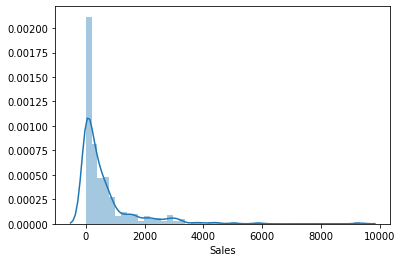

In [349]:
sns.distplot(final_data['Sales'])

In [433]:
final_data.head()

,Unnamed: 0,Sales,y_pred,SKU_Customer,Year,Month_No,MAD,MAPE
0,198,908.00,1355.940948,ALL OTHERS - US62338-91101,2018,10,0.330354,0.493327
1,200,884.00,1307.660955,ALL OTHERS - US62338-91101,2018,11,0.323984,0.479254
2,204,1433.40,1344.623901,ALL OTHERS - US62338-91101,2018,12,0.066023,0.061934
3,209,971.75,1327.359232,ALL OTHERS - US62338-91101,2019,1,0.267907,0.365947
4,213,1041.75,1335.907865,ALL OTHERS - US62338-91101,2019,2,0.220193,0.282369


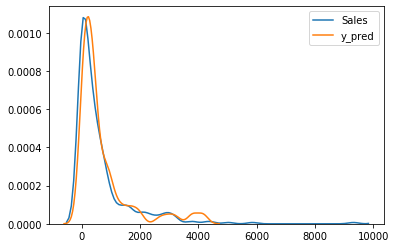

In [350]:
sns.kdeplot(final_data['Sales'])
sns.kdeplot(final_data['y_pred'])

In [359]:
final_data[final_data['Sales']>2000].MAD.mean()
final_data[final_data['Sales']<2000].MAD.mean()

0.6068816887333172

In [434]:
print(final_data[final_data['Sales']>1000].MAPE.mean())
print(final_data[final_data['Sales']<1000].MAPE.mean())

0.2772333413003364
2.805362811434578


In [368]:
final_data[final_data['Sales']>1000]

,Sales,y_pred,SKU_Customer,Year,Month_No,MAD,MAPE
204,1433.40,1344.623901,ALL OTHERS - US62338-91101,2018,12,0.066023,0.061934
213,1041.75,1335.907865,ALL OTHERS - US62338-91101,2019,2,0.220193,0.282369
217,1023.80,1372.870812,ALL OTHERS - US62338-91101,2019,3,0.254263,0.340956
512,1648.50,1720.691652,ALL OTHERS - US62338-92944,2018,10,0.041955,0.043792
514,1587.50,1672.411659,ALL OTHERS - US62338-92944,2018,11,0.050772,0.053488
518,1372.00,1709.374605,ALL OTHERS - US62338-92944,2018,12,0.197367,0.245900
523,1527.75,1692.109936,ALL OTHERS - US62338-92944,2019,1,0.097133,0.107583
527,1004.25,1700.658569,ALL OTHERS - US62338-92944,2019,2,0.409493,0.693461
531,1280.60,1737.621515,ALL OTHERS - US62338-92944,2019,3,0.263016,0.356881
845,1980.80,433.093859,ALL OTHERS - US62338-99058,2019,3,3.573604,0.781354


In [ ]:
final_data = final_data.sort_values(by='Sales')

In [ ]:
final_data['Sales_perc'] = round(100*final_data.Sales.cumsum(axis = 0) /final_data.Sales.sum(),2)

In [ ]:
test2 = test.copy()
test2['y_pred'] = np.array(gbm.predict(X_test_scaled))
test2['Customer_SKU'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']
test2['y_pred'] = np.array(test2.groupby(['Customer_SKU', 'Year', 'Month_No', ]).y_pred.transform('sum'))

final_data = test2[['Sales', 'y_pred', 'Customer_SKU', 'Year', 'Month_No']]
final_data = final_data.drop_duplicates()


final_data['MAD'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] == 0)&(final_data['Sales']!=0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['y_pred']))
 
final_data['MAPE'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] != 0)&(final_data['Sales']==0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['Sales']))

    
print(final_data['MAD'].mean())   
print(final_data['MAPE'].mean())     
print(rmse_by_month(final_data['Sales'], final_data['y_pred']))  

In [ ]:
test2 = test.copy()
test2['y_pred'] = np.array(ridge_cv.predict(X_test_scaled))
test2['SKU_Customer'] = test2.merge(data_labels, left_index=True, right_index=True)['SKU_Customer']

final_data = test2[['Sales', 'y_pred', 'SKU_Customer', 'Year', 'Month_No']]
final_data = final_data.drop_duplicates()


final_data['MAD'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] == 0)&(final_data['Sales']!=0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['y_pred']))
 
final_data['MAPE'] = np.where((final_data['y_pred'] == 0)&(final_data['Sales'] == 0), 0, \
                           np.where((final_data['y_pred'] != 0)&(final_data['Sales']==0),1, np.abs(final_data['y_pred']-final_data['Sales'])/final_data['Sales']))

    
print(final_data['MAD'].mean())   
print(final_data['MAPE'].mean())     
print(rmse_by_month(final_data['Sales'], final_data['y_pred']) )   